**Objectifs**

- Charger le modèle déjà entraîné dans le [notebook précédent](https://colab.research.google.com/drive/1v8Q8t6GG97aAVGyktspZ1FS9JvCFHwZs?usp=sharing)

- L'utiliser pour prédire un masque sur une simple image 2D d'un scan

- Depuis le volume d'un CT-Scan, utiliser le modèle pour construire une segmentation 3D de l'aorte 

In [16]:
!pip install pynrrd
import nrrd
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
#@title Utils

def resize(image: np.ndarray, height=512, width=512) -> np.ndarray:
    """
    Resizes the given input image to the specified height and width using linear interpolation.

    Args:
        image (np.ndarray): Input image to be resized.
        height (int, optional): The desired height for the resized image. Default is 512.
        width (int, optional): The desired width for the resized image. Default is 512.

    Returns:
        np.ndarray: The resized image with the specified height and width.
    """
    return cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)


def normalize(vol: np.ndarray) -> np.ndarray:
    """
    Normalizes the input volume by scaling its values to the range [0, 1].

    Args:
        vol (np.ndarray): Input volume to be normalized.

    Returns:
        np.ndarray: Normalized volume with values in the range [0, 1].
    """
    min, max = np.min(vol), np.max(vol)
    return (vol - min) / (max - min)


def apply_threshold(image: np.ndarray, threshold: float) -> np.ndarray:
    """
    Applies a threshold to the input image and returns a binary mask.

    Args:
        image (np.ndarray): Input image to apply the threshold.
        threshold (float): Threshold value between 0 and 1. All pixel values greater than the threshold
                           will be set to 1, and all other pixel values will be set to 0.

    Returns:
        np.ndarray: Binary mask (dtype: np.uint8) resulting from applying the threshold to the input image.
    """
    return ((image > threshold) * 1).astype(np.uint8)

def show_image_truemask_and_predicted(image: np.ndarray,
                                      true_mask: np.ndarray,
                                      predicted: np.ndarray,
                                      title: str = ''):
    """
    Displays the original image, true mask, and predicted mask side by side in a matplotlib figure.

    Args:
        image (np.ndarray): Original 2D image data.
        true_mask (np.ndarray): Ground truth mask for the input image.
        predicted (np.ndarray): Predicted mask generated by the model.
        title (str, optional): Title for the figure. Defaults to an empty string.
    """
    fig, (ax_image, ax_true_mask, ax_predicted_mask) = plt.subplots(1, 3, sharey=True)

    ax_image.imshow(image, cmap="gray")
    ax_image.set_title("Image")

    ax_true_mask.imshow(true_mask, cmap="gray")
    ax_true_mask.set_title("True mask")

    ax_predicted_mask.imshow(predicted, cmap="gray")
    ax_predicted_mask.set_title("Predicted")

    if title:
        fig.suptitle(title)

    fig.tight_layout()
    fig.show()

In [18]:
#@title Connexion à Google Drive
from google.colab import drive

drive.mount('/content/drive')


# SAMUEL
PP2_drive_sam_folder = Path("/content", "drive", "MyDrive", "L3", "S6", "PP2_drive_sam") 

# ILONA
# PP2_drive_sam_folder = Path("/content", "drive", ........,  "PP2_drive_sam") 

# ROSA
# PP2_drive_sam_folder = Path("/content", "drive", ........,  "PP2_drive_sam") 

# IBRAHIM
# PP2_drive_sam_folder = Path("/content", "drive", ........,  "PP2_drive_sam") 


AVT_DRIVE_FOLDER = PP2_drive_sam_folder / "datasets" / "AVT"

assert AVT_DRIVE_FOLDER.exists()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#@title Chargement du modèle

MODEL_FOLDER = PP2_drive_sam_folder / 'models' / "AVT-aortes_saines_512x512_3198-training_902-testing_10epochs_0.999124-accuracy_04-23-00h30"
MODEL_H5_FILE = MODEL_FOLDER /  "AVT-aortes_saines_512x512_3198-training_902-testing_10epochs_0.999124-accuracy_04-23-00h30.h5"

assert MODEL_H5_FILE.exists()

model = tf.keras.models.load_model(MODEL_H5_FILE)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

# Prédiction en 2D

In [20]:
#@title Prédiction

def get_2D_prediction(resized_slice: np.ndarray, model, verbose=0) -> np.ndarray:
    """
    Given a resized and normalized slice, returns the predicted mask using the provided model.

    Note: This function doesn't normalize the data nor does it resize the data to the appropriate shape for the model.

    Args:
        resized_slice (np.ndarray): Input resized and normalized image slice.
        model: Trained machine learning model to be used for making predictions.

    Returns:
        np.ndarray: The predicted mask generated by the model.
    """
    to_predict = resized_slice[..., np.newaxis]

    prediction = model.predict(np.expand_dims(to_predict, axis=0),verbose=verbose)

    return np.squeeze(prediction)


## Exemple :

In [21]:
#@title Chargement d'un volume de test

vol, _      = nrrd.read(AVT_DRIVE_FOLDER / 'Dongyang/D15/D15.nrrd' ) 
true_mask_vol, _ = nrrd.read(AVT_DRIVE_FOLDER / 'Dongyang/D15/D15.seg.nrrd' )

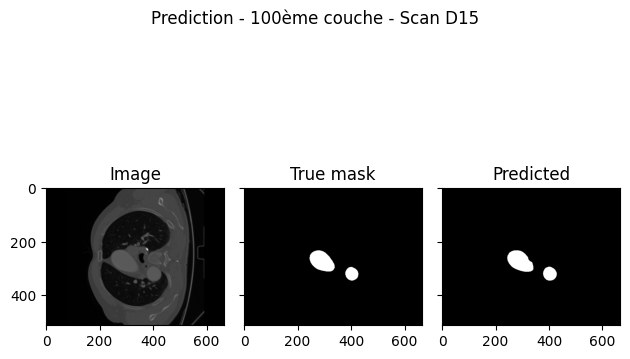

In [22]:
#@title Prédiction et affichage

k = 100 # Indice de la couche selon l'axe Z à afficher
image = vol[:,:,k]
true_mask = true_mask_vol[:,:,k]

# Resizing
original_shape = image.shape
resized = resize(image)

# Normalisation
normalized = normalize(resized)

# Prédiction
predicted = get_2D_prediction(normalized, model)

# Resizing à la taille originale
back_to_original_shape = resize(predicted, *original_shape)

# Application d'un seuil
THRESHOLD =0.1
thresholded = apply_threshold(back_to_original_shape, THRESHOLD)

# Affichage
show_image_truemask_and_predicted(image, true_mask, thresholded, 
                                  title = f'Prediction - {k}ème couche - Scan D15'
)


# En 3D


In [23]:
def predict_3D_mask(normalized_vol: np.ndarray, model, model_shape=(512, 512), verbose=0) -> np.ndarray:
    """
    Given a normalized 3D volume, predicts a 3D mask using the provided model.
    
    This function resizes each 2D slice of the input volume to match the model's input shape, predicts the mask using the model,
    and then resizes the predicted mask back to the original slice shape. Note that the returned mask is not a binary mask; it
    contains continuous values between 0 and 1 representing the model's prediction confidence.
    
    Args:
        normalized_vol (np.ndarray): A 3D numpy array representing the normalized input volume.
        model : A trained model that takes 2D slices as input and predicts the corresponding mask.
        model_shape (tuple): The shape (height, width) that the 2D slices should be resized to before being passed to the model.
    
    Returns:
        np.ndarray: A 3D numpy array of the same shape as the input volume, representing the predicted mask. Note that the
                    returned mask is not binary and contains continuous values between 0 and 1.
    """
    mask = np.zeros_like(normalized_vol)
    H, W, Z = normalized_vol.shape

    for z in range(Z):
        image = normalized_vol[:, :, z]
        resized = resize(image, *model_shape)  # Resize to fit the model input shape
        predicted = get_2D_prediction(resized, model, verbose=verbose)
        resized = resize(predicted, H, W)  # Resize back to the original image shape
        mask[:, :, z] = resized
    return mask


Pour reconstruire un volume de taille $512\times666\times136$ il faut:
 
- **20 minutes** sur l'environnement classqiue colab !  
- **9 secondes** avec GPU Premium. Il serait même possible de faire plus rapide en parallélisant la boucle for précédente

## Comment enregistrer le masque ?

Disons que nous avons obtenu le masque 3D pour un scan : 

```python
predicted_mask =  predict_3D_mask(normalized_vol, model)
thresholded = apply_threshold(predicted_mask, THRESHOLD)
```
**Comment enregistrer la segmentation 3D dans un fichier .nnrd ?**

### Naïvement : 
```python
nrrd.write('prediction.nrrd', thresholded)
```

Cette méthode pose un problème : 

![](https://cdn.discordapp.com/attachments/1050788953038540871/1105194908454760520/image.png)

Le résultat de la segmentation apparaît "écrasé", et si on la superpose avec le scan dans 3D Slicer par exemple, elle sera complètement décentrée.

### Explication du problème

Comme nous avons vu plus tôt, chaque fichier **.nnrd** vient avec un *header*, qui contient des metedata.

Analysons le *header* du fichier **D15** ouvert précédemment :  

```python
OrderedDict([('type', 'short'),
             ('dimension', 3),
             ('space', 'left-posterior-superior'),
             ('sizes', array([512, 666, 136])),
             ('space directions',
              array([[0.68359375, 0.        , 0.        ],
                     [0.        , 0.68359375, 0.        ],
                     [0.        , 0.        , 2.99259259]])),
             ('kinds', ['domain', 'domain', 'domain']),
             ('endian', 'little'),
             ('encoding', 'gzip'),
             ('space origin', array([ -171.15   ,   -57.33672, -1023.9001 ]))])
```

Trois attibuts sont à observer : (https://teem.sourceforge.net/nrrd/format.html#general.4)

- `space directions` : **Chaque colonne correspond à la direction et distance physique d'un axe**. Par défault, l'attribut est égal à la matrice identité. Ici nous pouvons voir que c'est une matrice diagonale, et elle définit donc un repère orthonormé dans le monde réel. Mais ici nous pouvons observer que pour dans la troisième dimension, (l'axe Z), la distance physique est de 3, tandis pour les autres dimensions elle est de 0.68. Ainsi, lorsqu'on sauvegarde notre segmentation sans ce *header*, les distances physiques des trois dimensions sont considérées comme égales et nous obtenous une segmentation "compressée".

- `space`: **Le système de coordonnées utilisé**. Ici, 'left-posterior-superior' **(LPS)** est un système courant en imagerie médicale, indiquant que les trois axes du repère pointent vers la gauche, l'arrière et le dessus du patient.

- `space origin` **détermine les coordonnées physiques du premier voxel**. Par défaut, ce vecteur est $[0,\ 0,\ 0]$ et donc la segmentation apparaît décentrée par rapport au volume si on ne le spécifie pas. 


### Solution

On **enregistre le *header*** lors du chargement du volume :

```python
vol, vol_header  = nrrd.read('./D15.nrrd') 
```

On en fait **une copie** que nous modifions si besoin pour le masque, puis on l'utilise pour enregistrer la segmentation.

```python
mask_header = vol_header.copy()

mask_header['type'] = 'uint8'
mask_header['encoding'] = 'gzip' # ou 'raw' pour pas de compression

# Enregistrement du masque avec le nouveau header
nrrd.write('output.nrrd', predicted_3D_mask, header=mask_header)
```


# Reconstructions 3D de tous les volumes de test

**Objectif** : Charger plein de modèles de test, les reconstruire et exporter les masques compressés pour pouvoir les visualiser avec 3D slicer

In [24]:
#@title Util
from typing import Tuple, Dict

CT_extremas = {
 'D1':  {'min': -1024, 'max': 3071},
 'D2':  {'min': -1024, 'max': 3071},
 'D3':  {'min': -1024, 'max': 6484},
 'D4':  {'min': -1024, 'max': 3071},
 'D5':  {'min': -1024, 'max': 3071},
 'D6':  {'min': -1024, 'max': 3071},
 'D7':  {'min': -1024, 'max': 3071},
 'D8':  {'min': -1024, 'max': 3071},
 'D9':  {'min': -1024, 'max': 2993},
 'D10': {'min': -1024, 'max': 3071},
 'D11': {'min': -1024, 'max': 3071},
 'D12': {'min': -1024, 'max': 3071},
 'D13': {'min': -1024, 'max': 2576},
 'D14': {'min': -1024, 'max': 3071},
 'D15': {'min': -1024, 'max': 3071},
 'D16': {'min': -1024, 'max': 3071},
 'D17': {'min': -1024, 'max': 14542},
 'D18': {'min': -1024, 'max': 3071},

 'K1':  {'min': 0,     'max': 4095},
 'K2':  {'min': 0,     'max': 4095},
 'K3':  {'min': 0,     'max': 4095},
 'K4':  {'min': 0,     'max': 4095},
 'K5':  {'min': 0,     'max': 4095},
 'K6':  {'min': 0,     'max': 4095},
 'K7':  {'min': 0,     'max': 4054},
 'K8':  {'min': 0,     'max': 4095},
 'K9':  {'min': 0,     'max': 3522},
 'K10': {'min': 0,     'max': 3993},
 'K11': {'min': 0,     'max': 2704},
 'K12': {'min': 0,     'max': 3531},
 'K13': {'min': 0,     'max': 4095},
 'K14': {'min': 0,     'max': 4045},
 'K15': {'min': 0,     'max': 3259},
 'K16': {'min': 0,     'max': 4055},
 'K17': {'min': 0,     'max': 2505},
 'K18': {'min': -2048, 'max': 5064},
 'K19': {'min': 0,     'max': 2636},
 'K20': {'min': 0,     'max': 4094},

 'R3':  {'min': 0, 'max': 4095},
 'R4':  {'min': 0, 'max': 2679},
 'R9':  {'min': 0, 'max': 4095},
 'R10': {'min': 0, 'max': 4095},
 'R11': {'min': 0, 'max': 4095},
 'R12': {'min': 0, 'max': 4095},
 'R13': {'min': 0, 'max': 4095},
 'R14': {'min': 0, 'max': 4095},
 'R15': {'min': 0, 'max': 4095},
 'R16': {'min': 0, 'max': 4095},
 'R17': {'min': 0, 'max': 4095},
 'R18': {'min': 0, 'max': 2880}
 }


def ct_name_from_path(volume_path:Path)->str:
  return volume_path.parts[-1].split('.')[0]

def load_and_normalize_volume(volume_path:Path)->np:
    
    # Open the volume file located at the given path, normalize its values, and return a NumPy array.

    # This function inspects the path to determine which CT-Scan it refers to and uses the CT_extremas
    # dictionary to perform an optimal normalization.

    # The file targeted by volume_path must be in the format XX.nrrd, where XX corresponds to a key in
    # CT_extremas.

    # Args:
    #     volume_path (Path): The path of the volume file to load and normalize.

    # Returns:
    #     np.ndarray: A NumPy array containing the normalized volume data.

    # Example:
    #     normalized_volume = load_and_normalize_volume(Path('CT-01.nrrd'))

  
  ct_name = ct_name_from_path(volume_path)
  extremas = CT_extremas[ct_name]
  min, max = extremas['min'], extremas['max']

  vol, header = nrrd.read(volume_path)

  vol[vol < min] = min
  vol[vol > max] = max
  vol -= min
  return vol / (max-min), header



In [25]:
#@title Définition des volumes de test

from pathlib import Path

testing_images_paths = [Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/Dongyang/D15/D15.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/Dongyang/D16/D16.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/Dongyang/D17/D17.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/Dongyang/D18/D18.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/KiTS/K17/K17.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/KiTS/K18/K18.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/KiTS/K19/K19.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/KiTS/K20/K20.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/Rider/R16/R16.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/Rider/R17/R17.nrrd'),
 Path('/content/drive/MyDrive/L3/S6/PP2_drive_sam/datasets/AVT/Rider/R18/R18.nrrd')]

In [26]:
#@title Constantes

PREDICTIONS_FOLDER = MODEL_FOLDER / 'predictions'
THRESHOLDS = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

In [27]:
#@title Le script

print(f'Début de la reconstruction de tous les volumes de tests : {" ".join([ct_name_from_path(p) for p in testing_images_paths])}')
for path in testing_images_paths:
  name = ct_name_from_path(path)

  # Chargement et prédiction
  print(f'Chargement de {name}')
  normalized_vol, vol_header = load_and_normalize_volume(path)
  predicted_mask = predict_3D_mask(normalized_vol, model)

  # Header du masque
  mask_header = vol_header.copy()
  mask_header['type'] = 'uint8'
  mask_header['encoding'] = 'gzip'

  for threshold in THRESHOLDS:
    thresholded = apply_threshold(predicted_mask, threshold)

    # Chemin de sauvegarde
    folder = PREDICTIONS_FOLDER / name
    os.makedirs(folder, exist_ok=True)
    file = folder / f'{name}-prediction-threshold-{threshold:.4f}.nrrd'

    # Ecriture
    nrrd.write(str(file), thresholded, header=mask_header)
    print(f"  Enregistrement du masque de {name} avec seuil de {threshold}")

print("Terminé ✅")


Début de la reconstruction de tous les volumes de tests : D15 D16 D17 D18 K17 K18 K19 K20 R16 R17 R18
Chargement de D15
  Enregistrement du masque de D15 avec seuil de 0.1
  Enregistrement du masque de D15 avec seuil de 0.2
  Enregistrement du masque de D15 avec seuil de 0.3
  Enregistrement du masque de D15 avec seuil de 0.4
  Enregistrement du masque de D15 avec seuil de 0.5
  Enregistrement du masque de D15 avec seuil de 0.6
  Enregistrement du masque de D15 avec seuil de 0.7
  Enregistrement du masque de D15 avec seuil de 0.8
  Enregistrement du masque de D15 avec seuil de 0.9
Chargement de D16
  Enregistrement du masque de D16 avec seuil de 0.1
  Enregistrement du masque de D16 avec seuil de 0.2
  Enregistrement du masque de D16 avec seuil de 0.3
  Enregistrement du masque de D16 avec seuil de 0.4
  Enregistrement du masque de D16 avec seuil de 0.5
  Enregistrement du masque de D16 avec seuil de 0.6
  Enregistrement du masque de D16 avec seuil de 0.7
  Enregistrement du masque de 